# ML regression with rampy.ml_regressor

Author: Charles Le Losq

**The `rampy.mlregressor` class performs automatic data scaling, hyperparameter grid search and provides access to popular algorithms (Support Vector, Kernel Rdige, Neural Nets) for using machine learning in a regression task implying spectroscopic data.** This function allows one to link any variable to a set of spectra with using a machine learning technique. 

Let's assume for the sack of example that we observe spectra D that are the combination of $k$ endmember spectra S with concentrations C, such that:

$$ D_{i,j} = C_{i,k} \times S_{k,j} $$

Here we assume a linear combination. In Python, assuming that the partial spectra are simple Gaussians, we can write the following.

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(42) # fixing the seed
import matplotlib
import matplotlib.pyplot as plt
import rampy as rp
from scipy.stats import norm

# create some fake data
x = np.arange(0,600,1.0)
nb_samples = 300 # number of samples in our dataset

S_1 = norm.pdf(x,loc=200.,scale=130.)
S_2 = norm.pdf(x,loc=400,scale=70)
S_true = np.vstack((S_1,S_2))
print("Number of samples:"+str(nb_samples))
print("Shape of partial spectra matrix:"+str(S_true.shape))

C_ = np.random.rand(nb_samples) #60 samples with random concentrations between 0 and 1
C_true = np.vstack((C_,(1-C_))).T
print("Shape of concentration matrix:"+str(C_true.shape))


Number of samples:300
Shape of partial spectra matrix:(2, 600)
Shape of concentration matrix:(300, 2)


We make some observations with random noise

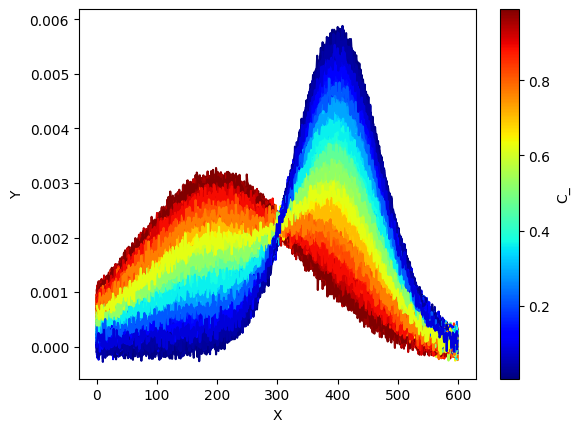

In [4]:
Obs = np.dot(C_true,S_true) + np.random.randn(nb_samples,len(x))*1e-4

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(C_),
    vmax=np.max(C_))

# choose a colormap
c_m = matplotlib.cm.jet

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

ax = plt.subplot()

# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm
for i in range(C_.shape[0]):
    plt.plot(x,
             Obs[i,:].T,
             color=s_m.to_rgba(C_[i]))

# we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m, ax=ax)
c_bar.set_label(r"C_")

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Machine Learning

We can train a machine learning algorithm to follow changes in D as a function of C, assuming we measured both quantities.

Rampy uses scikit_learn algorithms to do so in a easy way, with under-the-hood standardization and cross-validation. This is to use for "simple" projects, while more complicated things will required an ad hoc approach, directly using scikit-learn or any other relevant ML library.

For now, we will show how we can train neural networks to link D and C, such that we can predict C from new observations of D.

Let's first print the help to read the documentation...

In [5]:
help(rp.mlregressor)

Help on class mlregressor in module rampy.ml_regressor:

class mlregressor(builtins.object)
 |  mlregressor(x, y, **kwargs)
 |  
 |  use machine learning algorithms from scikit learn to perform regression between spectra and an observed variable.
 |  
 |  Attributes
 |  ----------
 |  x : {array-like, sparse matrix}, shape = (n_samples, n_features)
 |      Spectra; n_features = n_frequencies.
 |  y : array, shape = (n_samples,)
 |      Returns predicted values.
 |  X_test : {array-like, sparse matrix}, shape = (n_samples, n_features)
 |      spectra organised in rows (1 row = one spectrum) that you want to use as a testing dataset. THose spectra should not be present in the x (training) dataset. The spectra should share a common X axis.
 |  y_test : array, shape = (n_samples,)
 |      the target that you want to use as a testing dataset. Those targets should not be present in the y (training) dataset.
 |  algorithm : String,
 |      "KernelRidge", "SVM", "LinearRegression", "Lasso", "E

### Choice of the algorithm

Many popular algorithms are possible: [KernelRidge](http://scikit-learn.org/stable/modules/kernel_ridge.html),  [SVM](http://scikit-learn.org/stable/modules/kernel_ridge.html), [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), [NeuralNet](http://scikit-learn.org/stable/modules/neural_networks_supervised.html), [BaggingNeuralNet](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor).

LinearRegression, Lasso and ElasticNet are borned to linear problems, while KernelRidge, SVM, NeuralNet or BaggingNeuralNet can do both linear and non-linear problems. See the documentation of scikit-learn for further details, and all the articles online on those techniques. Those techniques need hyperparameters that are provided as a dictionary to `rampy.mlregressor`. I strongly encourage you to read the documentation on scikit-learn for the technique you want to use, in order to set those hyperparameters in the good range.

In the present case, we are dealing with a linear problem. We thus can use the [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) algorithms.

Machine learning algorithms need a training dataset, and their performance is evaluated on a "testing" dataset that is unseen of the algorithm. `rp.mlregressor` can split your dataset automatically, or you can choose to provide the two different datasets. Parameters for each algorithm are provided as a dictionary, see the documentation of [scikit-learn](http://scikit-learn.org/stable/index.html) for further details on them. The datasets are also standardized/normalised inside the function (if you don't know what this means, click [here](http://scikit-learn.org/stable/modules/preprocessing.html)). The type of scaling is changed by the `scaler` option.

`rp.mlregressor` creates an object that possess many attributes that are set by default but can be tweaked as preferred. The object also possess two methods: fit and predict, similar to the scikit-learn API. However, contrary to scikit-learn and due to the aim of the rampy.mlregressor class, the dataset is loaded upon initialisation of the object. Fit is performed at a second stage as one can switch easily between different algorithms.

The predict function works as that of a scikit-learn model, predicting new values from a new X dataset. Scaling is performed if rampy.mlregressor.scaling is set to True.

For now, we are going to load our data and create our mlregressor object:

In [6]:
model = rp.mlregressor(Obs,C_true[:,0].reshape(-1,1))

This default implementation takes care of splitting the dataset in training and testing subsets in a ratio 70/30, then scaled it with a standard scaler. The test size can be seen (and then set) as:

In [7]:
model.test_sz

0.3

The scaler is accessed as

In [8]:
model.scaler

'MinMaxScaler'

Is scaling active?

In [9]:
model.scaling

True

Now we are going to fit the data switching between the available algorithms in a loop. We use the default dictionnaries for hyperparameters, which will be optimised by gridsearch for most of the algorithms. This should be further tuned in a real-life application.

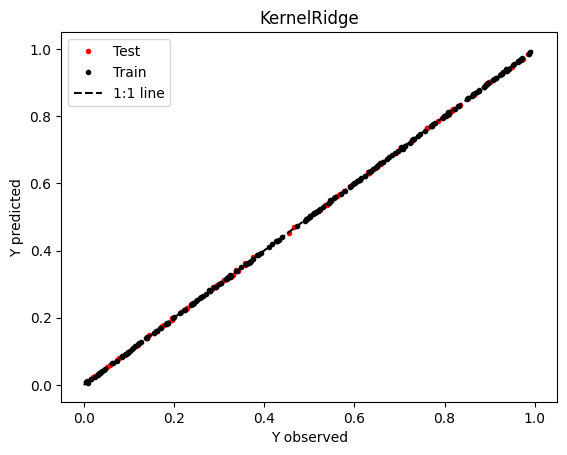

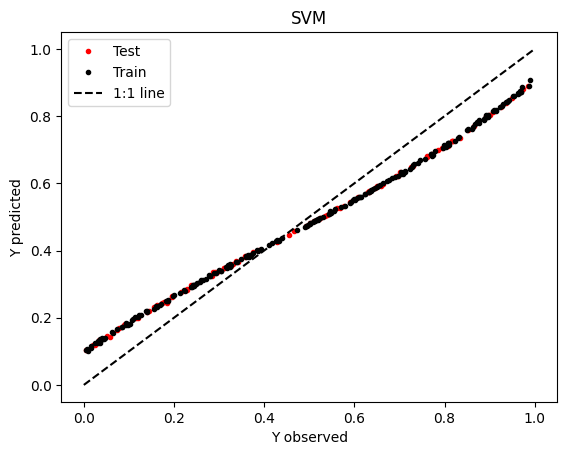

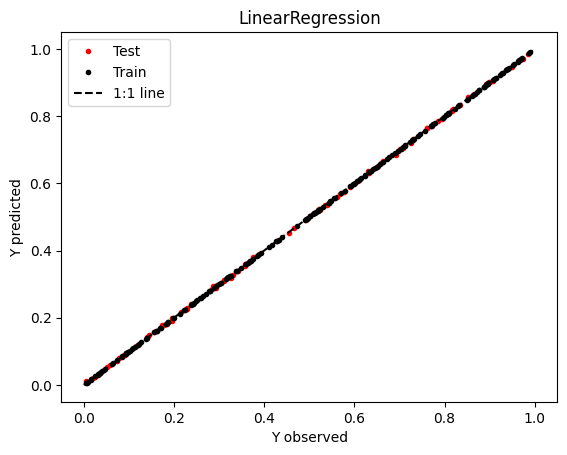

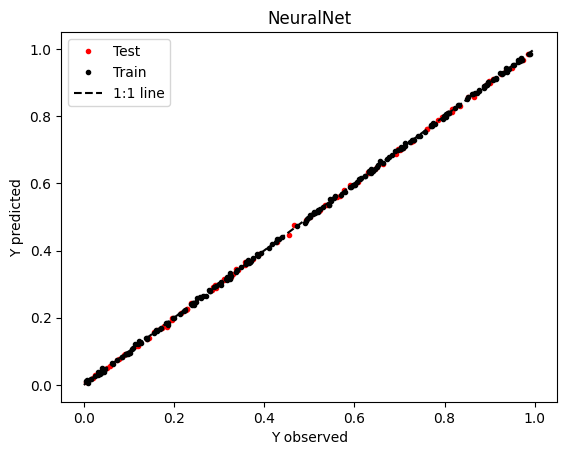

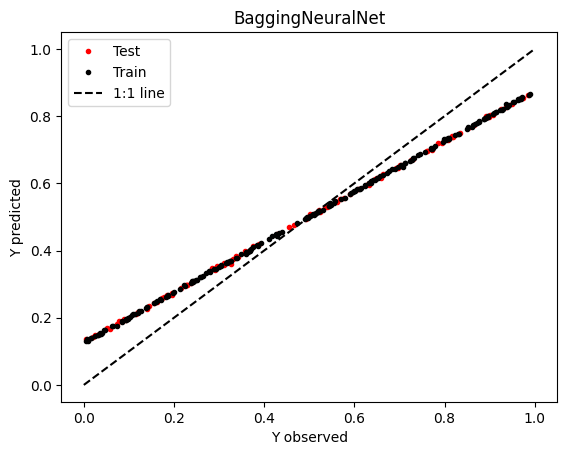

In [10]:
for i in ["KernelRidge", "SVM", "LinearRegression", "NeuralNet", "BaggingNeuralNet"]:
    model.algorithm = i
    model.user_kernel = 'poly'
    model.fit()
    plt.figure()
    plt.title(model.algorithm)
    plt.plot(model.y_test,model.prediction_test,"r.",label="Test")
    plt.plot(model.y_train,model.prediction_train,"k.",label="Train")
    plt.xlabel("Y observed")
    plt.ylabel("Y predicted")
    plt.plot([0,1],[0,1],"k--",label="1:1 line")
    plt.legend()

The support vector machine algorithm did not work well. We can try using a linear kernel, as the default one is set to radial basis function:

In [11]:
model.user_kernel

'poly'

and the hyperparameters are

In [12]:
model.param_svm

{'C': [1.0,
  2.0,
  5.0,
  10.0,
  50.0,
  100.0,
  500.0,
  1000.0,
  5000.0,
  10000.0,
  50000.0,
  100000.0],
 'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04])}

We can update it, and even provide other parameters if looking at sklearn help for SVM regressor.

In [13]:
model.param_grid_svm = dict(C= np.logspace(-5,5,40), gamma= np.logspace(-5,5,40))

We also update the kernel...

In [14]:
model.user_kernel = 'linear'

And run the training again... This will take longer as we explore a larger hyperparameter space...

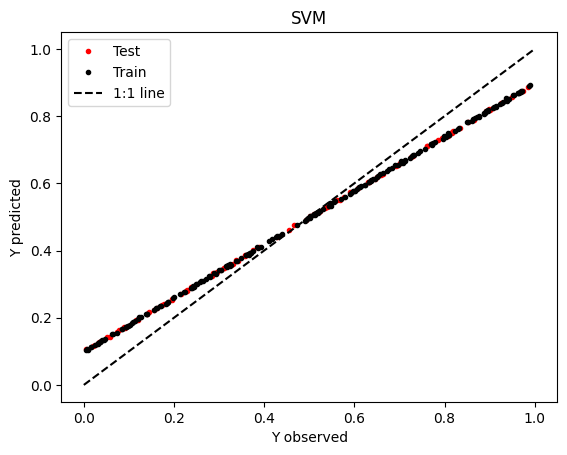

In [15]:
model.algorithm = "SVM"
model.fit()

plt.figure()
plt.title(model.algorithm)
plt.plot(model.y_test,model.prediction_test,"r.",label="Test")
plt.plot(model.y_train,model.prediction_train,"k.",label="Train")
plt.plot([0,1],[0,1],"k--",label="1:1 line")
plt.xlabel("Y observed")
plt.ylabel("Y predicted")
plt.legend()

### We can test to refit the data with a different kernel

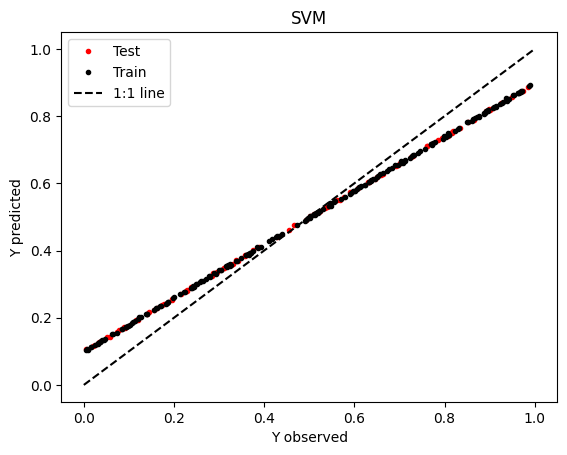

In [16]:
model.user_kernel = 'poly'
model.refit() # refit avoid running again model declaration and data standardisation.

plt.figure()
plt.title(model.algorithm)
plt.plot(model.y_test,model.prediction_test,"r.",label="Test")
plt.plot(model.y_train,model.prediction_train,"k.",label="Train")
plt.plot([0,1],[0,1],"k--",label="1:1 line")
plt.xlabel("Y observed")
plt.ylabel("Y predicted")
plt.legend()

Not really better. Maybe SVM is not the best technique for this problem, or we have a problem in the hyperparameters...

Let's try other algorithms, like neural nets and their ensemble version.

### Neural Nets

We see above that our ensemble method that trains 100 neural nets and get an estimate from their mean. It seems to work well. We can play with the hyperparameters.

First, we now train 1000 networks, not 100, by setting n_estimators to 1000.

We also tune the architecture of the network, by putting 10 activation functions in a single hidden layer.

Shape of the hidden layers:(3,)
Activation functions in the hidden layers:relu


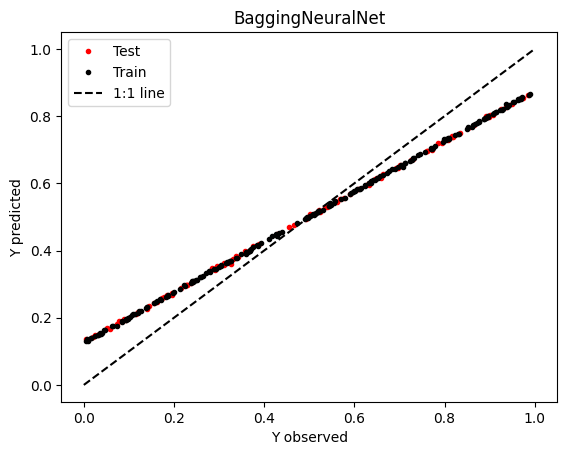

In [17]:
model.algorithm = "BaggingNeuralNet"
model.param_bagging = dict(n_estimators=1000, max_samples=100, max_features=len(x), bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=2, verbose=0)

print("Shape of the hidden layers:"+str(model.param_neurons['hidden_layer_sizes']))
print("Activation functions in the hidden layers:"+str(model.param_neurons['activation']))

model.fit()
plt.figure()
plt.title(model.algorithm)
plt.plot(model.y_test,model.prediction_test,"r.",label="Test")
plt.plot(model.y_train,model.prediction_train,"k.",label="Train")
plt.plot([0,1],[0,1],"k--",label="1:1 line")
plt.xlabel("Y observed")
plt.ylabel("Y predicted")
plt.legend()

The networks perform not very well with this setup... The [BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) uses a base model, which actually is the MLPregressor used when setting `rampy.mlregressor.algorithm = "NeuralNets"`. It is possible to tweak the hyperparameters of the base regressor to try improving the fit. 

We see above that we have 1 hidden layer with 3 RELU units. Let's have 3 layers with 10 units in each layer. This is a deeper network that can work well on complex problems. We increase the number of hidden layers (in a tuple), as described in scikit-learn [MLPregressor help](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html):

In [18]:
model.param_neurons['hidden_layer_sizes'] = (10,) 
model.param_neurons['activation'] = "relu" # we also could try changing the activation to tanh. Try it!

Shape of the hidden layers:(10,)
Activation functions in the hidden layers:relu


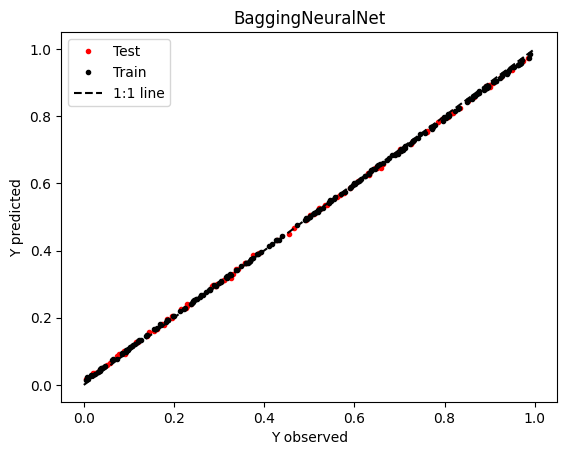

In [19]:
model.algorithm = "BaggingNeuralNet"
print("Shape of the hidden layers:"+str(model.param_neurons['hidden_layer_sizes']))
print("Activation functions in the hidden layers:"+str(model.param_neurons['activation']))
model.fit()
plt.figure()
plt.title(model.algorithm)
plt.plot(model.y_test,model.prediction_test,"r.",label="Test")
plt.plot(model.y_train,model.prediction_train,"k.",label="Train")
plt.plot([0,1],[0,1],"k--",label="1:1 line")
plt.xlabel("Y observed")
plt.ylabel("Y predicted")
plt.legend()

### Predicting new values from this model

Now we have made new observations, and we want to predict C given D. We can do that easily:

generating 10 new observations
Shape of concentration matrix:(10, 2)


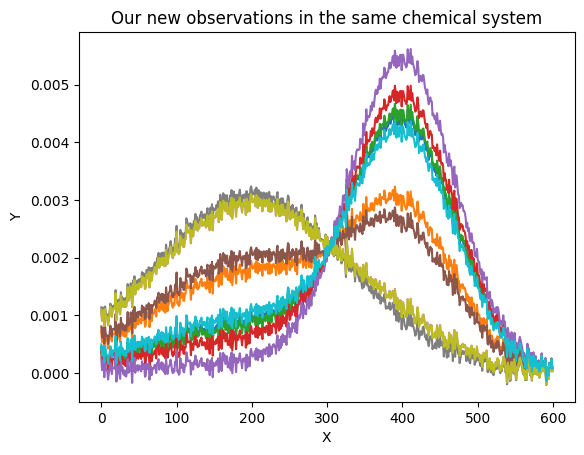

In [20]:
print("generating 10 new observations")
C_new_ = np.random.rand(10) #10 samples with random concentrations between 0 and 1
C_new_true = np.vstack((C_new_,(1-C_new_))).T
print("Shape of concentration matrix:"+str(C_new_true.shape))

noise_new = np.random.randn(len(x))*1e-4
Obs_new = np.dot(C_new_true,S_true) + noise_new

plt.plot(x,Obs_new.T)
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Our new observations in the same chemical system")
plt.show()

### Predictions!

In [21]:
C_new_predicted = model.predict(Obs_new)

### Comparison!

Text(0, 0.5, 'Y predicted')

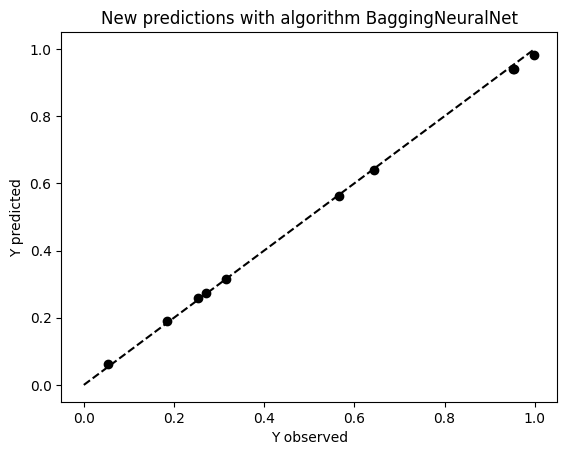

In [22]:
plt.figure()
plt.title("New predictions with algorithm "+model.algorithm)
plt.plot(C_new_,C_new_predicted,"ko")
plt.plot([0,1],[0,1],"k--",label="1:1 line")
plt.xlabel("Y observed")
plt.ylabel("Y predicted")

### RMSE!

In [23]:
from sklearn.metrics import mean_squared_error as mse

print("mean RMSE between newly predicted and observed data:" + str(np.sqrt(mse(C_new_,C_new_predicted))))

mean RMSE between newly predicted and observed data:0.009187505874316186
